In [29]:
import pandas as pd
import matplotlib.pyplot as plt
data=pd.read_csv('/content/drive/MyDrive/Size_effects/DATA/sample_longitudinals.csv')
post_count = data.groupby('post_id')['from_id'].nunique().reset_index(name='post_size')
post_from_count = data.groupby(['post_id', 'from_id']).size().reset_index(name='interaction_len')
joined_df = pd.merge(post_count, post_from_count, on='post_id', how='inner')

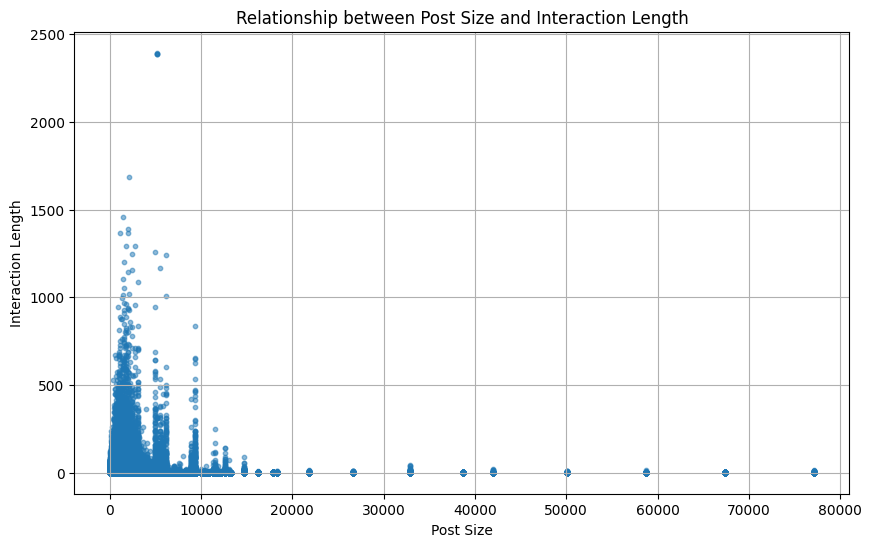

In [41]:
# prompt: metti alpha e rimpicciolisci i punti

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.scatter(joined_df['post_size'], joined_df['interaction_len'], alpha=0.5, s=10)  # Adjust alpha and s for transparency and size
plt.xlabel('Post Size')
plt.ylabel('Interaction Length')
plt.title('Relationship between Post Size and Interaction Length')
plt.grid(True)
plt.show()


## Outreach for each post

I successivi due blocchi consentono di fare un join anche se non abbiamo sufficinte ram, spezzando il left in chunks.

In [17]:
import pandas as pd
import os
from tqdm import tqdm
import numpy as np

sample_size_pages=1

# Read posts data
posts = pd.read_csv('/content/drive/MyDrive/Size_effects/DATA/sample_posts.csv',
                     usecols=['created_time', 'page_id', 'post_id'],
                     encoding='ISO-8859-1')
posts = posts[['created_time', 'page_id', 'post_id']]
random_pages = np.random.choice(posts['page_id'].unique(), size=sample_size_pages, replace=False)
filtered_posts = posts[posts['page_id'].isin(random_pages)]

# Read likes data
likes = pd.read_csv('/content/drive/MyDrive/Size_effects/DATA/sample_likes.csv', usecols=['from_id', 'post_id'], encoding='ISO-8859-1')
campione=filtered_posts['post_id'].unique()
filtered_likes = likes[likes['post_id'].isin(campione)]

# Merge the filtered posts and likes DataFrames
merged_df = pd.merge(filtered_posts, filtered_likes, on='post_id', how='right')

merged_df.to_csv(f'/content/drive/MyDrive/Size_effects/DATA/sample_likes_complete.csv', index=False)


In [28]:
post_likers=unique_likers(merged_df)

{'523592704341166_1084267341607030': 367,
 '523592704341166_1084185781615186': 367,
 '523592704341166_1081254031908361': 1292,
 '523592704341166_1079995318700899': 1292,
 '523592704341166_1078663892167375': 2136,
 '523592704341166_1076641932369571': 2136,
 '523592704341166_1076132342420530': 2136,
 '523592704341166_1076121269088304': 2136,
 '523592704341166_1075609269139504': 2136,
 '523592704341166_1075542405812857': 2136,
 '523592704341166_1075091355857962': 2052,
 '523592704341166_1074753569225074': 2052,
 '523592704341166_1074646559235775': 2052,
 '523592704341166_1074614832572281': 2052,
 '523592704341166_1074598302573934': 2052,
 '523592704341166_1073932382640526': 2052,
 '523592704341166_1072455446121553': 2052,
 '523592704341166_1070144706352627': 1292,
 '523592704341166_1069213013112463': 1292,
 '523592704341166_1065887270111704': 543,
 '523592704341166_1065320160168415': 549,
 '523592704341166_1065313713502393': 549,
 '523592704341166_1064074986959599': 549,
 '523592704341166

In [45]:
import pandas as pd
post_likers = unique_likers(merged_df)
post_likers_df = pd.DataFrame(list(post_likers.items()), columns=['post_id', 'unique_likers'])
post_likers_df.reset_index(drop=True, inplace=True)

merged_df_result = pd.merge(joined_df[['interaction_len','post_id']], post_likers_df, on='post_id', how='right').dropna()



,interaction_len,post_id,unique_likers
0,1.0,523592704341166_1084267341607030,367
1,2.0,523592704341166_1084267341607030,367
2,1.0,523592704341166_1084267341607030,367
3,1.0,523592704341166_1084267341607030,367
4,1.0,523592704341166_1084267341607030,367
...,...,...,...
886,3.0,523592704341166_529835300383573,18
887,1.0,523592704341166_529835300383573,18
888,1.0,523592704341166_529835300383573,18
899,1.0,523592704341166_524570247576745,8


In [ ]:
merged_df_result.to_csv('/content/drive/MyDrive/SAM/singola_pagina.csv')

Functions

In [26]:
import pandas as pd

def unique_likers(likes):
    # Ensure 'created_at' is in datetime format
    likes['created_at'] = pd.to_datetime(likes['created_time'])

    # Create a 'week' column from 'created_at'
    likes['week'] = likes['created_at'].dt.to_period('W')  # Create weekly periods

    post_likers = {}  # Initialize a dictionary to store the unique number of likers for each post

    # Loop through each unique post in the DataFrame
    for idx, post in likes[['post_id', 'week', 'page_id']].drop_duplicates().iterrows():
        post_id = post['post_id']
        post_week = post['week']
        page_id = post['page_id']

        # Calculate previous and next weeks as Period
        prev_week = post_week - 1  # Previous week
        next_week = post_week + 1    # Next week

        # Filter likes for the same page and in the three weeks (previous, current, and next)
        likers_in_weeks = likes[
            (likes['page_id'] == page_id) &
            (likes['week'].isin([prev_week, post_week, next_week]))
        ]['from_id'].unique()

        # Store the count of unique likers for the current post
        post_likers[post_id] = len(likers_in_weeks)

    return post_likers
